<a href="https://colab.research.google.com/github/scottleebroda/HSG-programing-project-Scott/blob/main/Scott_Mortgage_Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install numpy-financial

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Do you want to calculate a mortgage? (yes/no): yes
Enter the principal amount ($): 1000000
Enter the annual interest rate (%): 1.5
Enter the number of years: 30
Enter the maximum monthly payment you can afford ($): 2000
Enter the initial rate period for ARM (in years): 15
Enter the initial interest rate for ARM (%): 1.2
Do you want to fully repay your loan at maturity? (yes/no): yes
Warning! The monthly payment for CPM is above your budget.
Warning! The monthly payment for CAM at some point goes above your budget.
Warning! The monthly payment for ARM at some point goes above your budget.


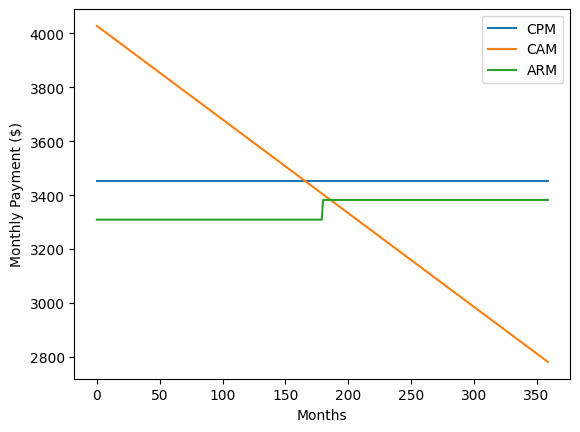

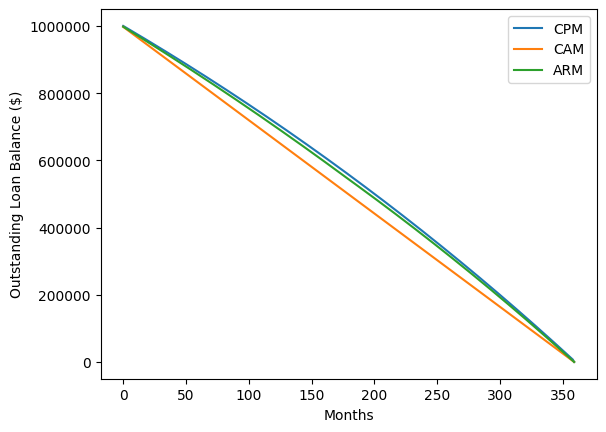

,Mortgage Type,Avg. Monthly Payment,Total Payment,Interest Paid
0,CPM,"$3,451.20","$1,242,432.76","$242,432.76"
1,CAM,"$3,404.51","$1,225,625.00","$225,625.00"
2,ARM,"$3,345.62","$1,204,424.31","$204,424.31"


Do you want to calculate a mortgage? (yes/no): no


In [20]:
# Importing  libraries
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import pandas as pd


# Function to calculate payments for Constant Payment Mortgage (CPM)
def calculate_payments_cpm(principal, interest_rate, years, max_monthly_payment, full_repay, final_balance=0):
    monthly_interest_rate = interest_rate / 100 / 12  # Converting annual interest rate to monthly
    months = years * 12 # Total months for the mortgage
    if not full_repay:  # If loan is not to be fully repaid
        principal = principal - final_balance # Reduce principal by the final balance intended to be left
    monthly_payment = npf.pmt(monthly_interest_rate, months, -principal)  # Calculate monthly payment
    loan_balance = np.zeros(months) # Initialize loan balance array
    loan_balance[0] = principal # Set initial loan balance

    for m in range(1, months):
        interest_payment = loan_balance[m - 1] * monthly_interest_rate    # Calculate interest payment
        principal_payment = monthly_payment - interest_payment    # Calculate principal payment
        loan_balance[m] = loan_balance[m - 1] - principal_payment  # Update loan balance

    loan_balance[-1] = final_balance        #  final balance

# Check if monthly payment exceeds the budget
    if monthly_payment > max_monthly_payment:
        print("Warning! The monthly payment for CPM is above your budget.")
    return np.repeat(monthly_payment, months), loan_balance

# Function to calculate payments for Constant Amortization Mortgage (CAM)
def calculate_payments_cam(principal, interest_rate, years, max_monthly_payment, full_repay, final_balance=0):
    monthly_interest_rate = interest_rate / 100 / 12
    months = years * 12
    if not full_repay:
        principal = principal - final_balance
    principal_payment = principal / months
    loan_balance = np.zeros(months)
    total_monthly_payment = np.zeros(months)
    max_warning_flag = False

    for m in range(months):
        interest_payment = loan_balance[m - 1] * monthly_interest_rate if m > 0 else principal * monthly_interest_rate
        total_monthly_payment[m] = principal_payment + interest_payment
        loan_balance[m] = loan_balance[m - 1] - principal_payment if m > 0 else principal - principal_payment

        if total_monthly_payment[m] > max_monthly_payment and not max_warning_flag:
            print("Warning! The monthly payment for CAM at some point goes above your budget.")
            max_warning_flag = True

    loan_balance[-1] = final_balance
    return total_monthly_payment, loan_balance

# Function to calculate payments for Adjustable Rate Mortgage (ARM)
def calculate_payments_arm(principal, interest_rate, years, initial_rate_period, initial_interest_rate, max_monthly_payment, full_repay, final_balance=0):
    monthly_interest_rate = interest_rate / 100 / 12
    initial_monthly_interest_rate = initial_interest_rate / 100 / 12
    months = years * 12
    initial_months = min(months, initial_rate_period * 12)
    later_months = months - initial_months
    monthly_payment = np.zeros(months)
    loan_balance = np.zeros(months)
    loan_balance[0] = principal
    max_warning_flag = False

    if not full_repay:
        principal = principal - final_balance

    for m in range(initial_months):
        monthly_payment[m] = npf.pmt(initial_monthly_interest_rate, months, -principal)
        interest_payment = loan_balance[m - 1] * initial_monthly_interest_rate if m > 0 else principal * initial_monthly_interest_rate
        principal_payment = monthly_payment[m] - interest_payment
        loan_balance[m] = loan_balance[m - 1] - principal_payment if m > 0 else principal - principal_payment

        if monthly_payment[m] > max_monthly_payment and not max_warning_flag:
            print("Warning! The monthly payment for ARM at some point goes above your budget.")
            max_warning_flag = True

    for m in range(initial_months, months):
        monthly_payment[m] = npf.pmt(monthly_interest_rate, months-m, -loan_balance[m - 1])
        interest_payment = loan_balance[m - 1] * monthly_interest_rate
        principal_payment = monthly_payment[m] - interest_payment
        loan_balance[m] = loan_balance[m - 1] - principal_payment

    loan_balance[-1] = final_balance
    return monthly_payment, loan_balance




# Function to plot the monthly payments for CPM, CAM, and ARM
def plot_payments(payments_cpm, payments_cam, payments_arm, years):
    months = np.arange(years * 12)
    plt.plot(months, np.insert(payments_cpm, 0, None)[1:], label='CPM')
    plt.plot(months, np.insert(payments_cam, 0, None)[1:], label='CAM')
    plt.plot(months, np.insert(payments_arm, 0, None)[1:], label='ARM')
    plt.xlabel('Months')
    plt.ylabel('Monthly Payment ($)')
    plt.ticklabel_format(style='plain')  # Disable scientific notation
    plt.legend()
    plt.show()

# Function to plot the loan balance for CPM, CAM, and ARM
def plot_loan_balance(loan_balance_cpm, loan_balance_cam, loan_balance_arm, years):
    months = np.arange(years * 12)
    plt.plot(months, loan_balance_cpm, label='CPM')
    plt.plot(months, loan_balance_cam, label='CAM')
    plt.plot(months, loan_balance_arm, label='ARM')
    plt.xlabel('Months')
    plt.ylabel('Outstanding Loan Balance ($)')
    plt.ticklabel_format(style='plain')  # Disable scientific notation
    plt.legend()
    plt.show()

# Function to calculate the mortgage based on user inputs

def mortgage_calculator():
    while True:
        try:
            principal = float(input("Enter the principal amount ($): "))
            break
        except ValueError:
            print("Invalid ! Please enter a number.")
    while True:
        try:
            interest_rate = float(input("Enter the annual interest rate (%): "))
            break
        except ValueError:
            print("Invalid ! Please enter a number.")
    while True:
        try:
            years = int(input("Enter the number of years: "))
            break
        except ValueError:
            print("Invalid ! Please enter an integer.")
    while True:
        try:
            max_monthly_payment = float(input("Enter the maximum monthly payment you can afford ($): "))
            break
        except ValueError:
            print("Invalid ! Please enter a number.")
    while True:
        try:
            initial_rate_period = int(input("Enter the initial rate period for ARM (in years): "))
            break
        except ValueError:
            print("Invalid ! Please enter an integer.")
    while True:
        try:
            initial_interest_rate = float(input("Enter the initial interest rate for ARM (%): "))
            break
        except ValueError:
            print("Invalid ! Please enter a number.")
    while True:
        full_repayment = input("Do you want to fully repay your loan at maturity? (yes/no): ")
        if full_repayment.lower() in ['yes', 'no']:
            full_repay = full_repayment.lower() == 'yes'
            break
        else:
            print("Invalid ! Please enter either 'yes' or 'no'.")
    if not full_repay:
        while True:
            try:
                final_balance = float(input("Enter the outstanding loan balance you want at maturity ($): "))
                break
            except ValueError:
                print("Invalid ! Please enter a number.")
    else:
        final_balance = 0
    
    # Calculate payments and loan balance for each mortgage type
    payments_cpm, loan_balance_cpm = calculate_payments_cpm(principal, interest_rate, years, max_monthly_payment, full_repay, final_balance)
    payments_cam, loan_balance_cam = calculate_payments_cam(principal, interest_rate, years, max_monthly_payment, full_repay, final_balance)
    payments_arm, loan_balance_arm = calculate_payments_arm(principal, interest_rate, years, initial_rate_period, initial_interest_rate, max_monthly_payment, full_repay, final_balance)
    #plot the payment and loan balance
    plot_payments(payments_cpm, payments_cam, payments_arm, years)
    plot_loan_balance(loan_balance_cpm, loan_balance_cam, loan_balance_arm, years)
    
    # Create DataFrame for mortgage comparison
    data = {
        'Mortgage Type': ['CPM', 'CAM', 'ARM'],
        'Avg. Monthly Payment': [np.mean(payments_cpm), np.mean(payments_cam), np.mean(payments_arm)],
        'Total Payment': [np.sum(payments_cpm), np.sum(payments_cam), np.sum(payments_arm)],
        'Interest Paid': [np.sum(payments_cpm) - principal, np.sum(payments_cam) - principal, np.sum(payments_arm) - principal]
    }
    df = pd.DataFrame(data)
    df['Avg. Monthly Payment'] = df['Avg. Monthly Payment'].apply(lambda x: '${:,.2f}'.format(x))
    df['Total Payment'] = df['Total Payment'].apply(lambda x: '${:,.2f}'.format(x))
    df['Interest Paid'] = df['Interest Paid'].apply(lambda x: '${:,.2f}'.format(x))
    display(df)

# Main loop that prompts user to calculate a mortgage or not
while True:
    repeat = input("Do you want to calculate a mortgage? (yes/no): ")
    if repeat.lower() == 'yes':
        mortgage_calculator()
    elif repeat.lower() == 'no':
        break
    else:
        print("Invalid ! Please enter either 'yes' or 'no'.")
